# This notebook merges data from OGLE II and III (from Bird+2012) with data from OGLE IV

In [1]:
import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lombscargle
import pandas as pd
import re
import glob

data_dir = "../data/"
list_from_bird_dir = "../data/ogle2_and_3/xrom_fixed/list.txt"

In [3]:
import psutil
psutil.Process().nice(5)# if on *ux

# check coverage of the data 

In [140]:
# # make a look up dictionary for source indices
# look_up_Bird = {}

# with open('../data/ogle2_and_3/xrom_fixed/lookup.txt') as f:
#     lines = f.readlines()
#     for line in lines:
#         look_up_Bird[int(line.split(" ")[0])] = line.split(" ")[1].replace("\n", "")

In [5]:
# load the list of SPX names from Bird+2012 and their corresponding IDs

with open(list_from_bird_dir) as f:
    lines = f.readlines()

ids_names = [re.split("\s+", line)[:3] for line in lines]
ids_names = [x[1:] if (x[0] == '') else x for x in ids_names]
ids_names = [x[:2] if len(x)>2 else x for x in ids_names]
ids_names = [x for x in ids_names if len(x)>1]
ids_names_bird = {int(sxp_id): sxp_name.lower() for sxp_id,sxp_name in ids_names}

In [238]:
# check the dates that the different data sets span for each source

# data_sets = ["ogle2_3/xrom_fixed/phot_I_calib/", "ogle3/", "ogle4/"]


ogle2_3_start_end = {}
ogle3_start_end = {}
ogle4_start_end = {}
maxima_2_3 = {}
maxima_3 = {}
minima_2_3 = {}
minima_3 = {}

for source_index, source_name in ids_names_bird.items():
    source_data = np.loadtxt('../data/ogle2_and_3/xrom_fixed/phot_I_calib/{}.dat'.format(source_index))
    ogle2_3_start_end[source_name] = (source_data[0,0], source_data[-1,0])
    try:
        maxima_2_3[source_name] = source_data[:,0][-740:][np.argmin(source_data[:,1])]
        minima_2_3[source_name] = source_data[:,0][-740:][np.argmax(source_data[:,1])]
    except:
        maxima_2_3[source_name] = source_data[:,0][np.argmin(source_data[:,1])]
        minima_2_3[source_name] = source_data[:,0][np.argmax(source_data[:,1])]

    
for source_index, source_name in ids_names_bird.items():
    try:
        source_data = np.loadtxt('../data/ogle3/{}/phot.dat'.format(source_name))
        ogle3_start_end[source_name] = (source_data[0,0]-2450000, source_data[-1,0]-2450000)
        maxima_3[source_name] = source_data[:,0][np.argmin(source_data[:,1])]-2450000
        minima_3[source_name] = source_data[:,0][np.argmax(source_data[:,1])]-2450000
    except:
        print("{} not found in OGLE3".format(source_name))
        ogle3_start_end[source_name] = (np.nan, np.nan)
        maxima_3[source_name] = np.nan
        minima_3[source_name] = np.nan

        
for source_index, source_name in ids_names_bird.items():
    try:
        source_data = np.loadtxt('../data/ogle4/{}/phot.dat'.format(source_name))
        ogle4_start_end[source_name] = (source_data[0,0]-2450000, source_data[-1,0]-2450000)
    except:
        print("{} not found in OGLE4".format(source_name))
        ogle4_start_end[source_name] = (np.nan, np.nan)

ogle_dates = pd.DataFrame({"Source":list(ids_names_bird.values()),
        "Bird2_3_start":[ogle2_3_start_end[x][0] for x in ids_names_bird.values()],
                           "Bird2_3_end":[ogle2_3_start_end[x][1] for x in ids_names_bird.values()], 
                           "ogle3_start":[ogle3_start_end[x][0] for x in ids_names_bird.values()], 
                           "ogle3_end":[ogle3_start_end[x][1] for x in ids_names_bird.values()],
                           
                           "Bird_ogle3_end_diff":[ogle3_start_end[x][1]-ogle2_3_start_end[x][1] for x in ids_names_bird.values()],
                           
                           "ogle4_start":[ogle4_start_end[x][0] for x in ids_names_bird.values()], 
                           "ogle4_end":[ogle4_start_end[x][1] for x in ids_names_bird.values()],
                          "maximum_Bird":[maxima_2_3[x] for x in ids_names_bird.values()],
                          "maximum3":[maxima_3[x] for x in ids_names_bird.values()],
                        "minimum_Bird":[minima_2_3[x] for x in ids_names_bird.values()],
                          "minimum3":[minima_3[x] for x in ids_names_bird.values()]},
                         index = np.array(range(len(ids_names_bird.values())))+1)

ogle_dates = ogle_dates[["Source","Bird2_3_start", "Bird2_3_end", "ogle3_start", "ogle3_end","Bird_ogle3_end_diff", "maximum_Bird", "maximum3","minimum_Bird", "minimum3", "ogle4_start", "ogle4_end"]]

sxp3.34 not found in OGLE3
sxp6.85 not found in OGLE3
sxp6.88 not found in OGLE3
sxp11.5 not found in OGLE3
sxp65.8 not found in OGLE3
sxp348 not found in OGLE3
rx-j0516.0-6916 not found in OGLE4
xmmu-j054134.7-682550 not found in OGLE4
rx-j0544.1-7100 not found in OGLE4
sxp2.763 not found in OGLE4
sxp18.3 not found in OGLE4
sxp31.0 not found in OGLE4
sxp152.1 not found in OGLE4
sxp202b not found in OGLE4
sxp264 not found in OGLE4
sxp455a not found in OGLE4
sxp455b not found in OGLE4
sxp893 not found in OGLE4
ma93-798 not found in OGLE4


In [239]:
start_short = []
finish_short = []

tolerance_days=0.01

for name, source in ogle_dates.iterrows():
    if source.Bird2_3_start-tolerance_days > source.ogle3_start:
        start_short.append(name)
        print(source.name, "Tony's data starts too late")
    if source.Bird2_3_end+tolerance_days < source.ogle3_end:
        finish_short.append(name)
        print(source.name, "Tony's data ends too early")

ogle_dates.style.apply(lambda x: ['background: lightgreen' 
                                  if (x.name in start_short)
                                  else 'background: yellow'
                                  if (x.name in finish_short)
                                  else '' for i in x], axis=1)

4 Tony's data starts too late
4 Tony's data ends too early
5 Tony's data starts too late
7 Tony's data ends too early
12 Tony's data ends too early
18 Tony's data ends too early
19 Tony's data ends too early
27 Tony's data ends too early
28 Tony's data ends too early
31 Tony's data ends too early
35 Tony's data ends too early
36 Tony's data ends too early
38 Tony's data ends too early
41 Tony's data ends too early
42 Tony's data ends too early
45 Tony's data ends too early
49 Tony's data ends too early
51 Tony's data ends too early
52 Tony's data ends too early
53 Tony's data ends too early


,Source,Bird2_3_start,Bird2_3_end,ogle3_start,ogle3_end,Bird_ogle3_end_diff,maximum_Bird,maximum3,minimum_Bird,minimum3,ogle4_start,ogle4_end
1,rx-j0513.9-6951,2167.85,4951.52,2167.85,4951.52,6.18456e-11,2605.75,2605.75,2867.92,4043.68,5260.61,8921.57
2,rx-j0516.0-6916,457.65,4953.52,2112.93,4953.52,-1.33696e-10,922.48,3058.59,4473.7,3455.52,nan,nan
3,rx-j0520.5-6932,455.675,4953.52,2112.93,4953.52,-1.33696e-10,1329.5,2135.92,4394.72,4394.72,5260.61,8921.57
4,xmmu-j054134.7-682550,2187.3,4947.03,2168.85,4947.53,0.50151,3747.34,4348.88,2251.18,2237.63,nan,nan
5,cal-83,2187.8,4947.53,2168.85,4947.53,1.17325e-10,3088.59,3088.59,4867.77,4867.77,5261.66,8921.59
6,rx-j0544.1-7100,2168.87,4933.59,2168.87,4933.59,1.76442e-10,4378.78,4378.78,2335.52,2335.52,nan,nan
7,sxp0.92,625.43,4866.05,2090.91,4866.55,0.50206,667.385,2222.63,3633.18,4080.6,5346.92,8869.58
8,sxp2.37,2086.93,4868.56,2086.93,4868.56,-5.54792e-11,4475.55,4475.55,2213.68,2213.68,5346.92,8759.65
9,sxp2.763,2086.93,4868.57,2086.93,4868.57,-2.29193e-10,3020.6,2850.92,4120.58,4120.58,nan,nan
10,sxp7.78,2086.89,4952.92,2086.89,4952.92,-6.00267e-11,2521.83,2472.92,3195.94,3177.92,5346.92,8869.57


# some of the sources in Bird+2012 data set seem to be off-set by -0.5 with respect to OGLE 3, but some do not 

# view the data for a few sources

sxp91.1


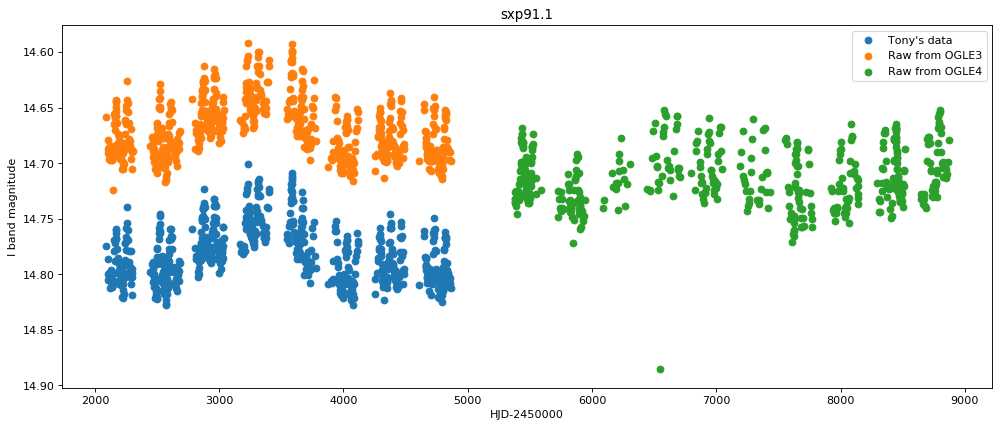

In [241]:
source_index = 23

lc_bird = np.loadtxt('../data/ogle2_and_3/xrom_fixed/phot_I_calib/{}.dat'.format(source_index))
lc_ogle3 = np.loadtxt('../data/ogle3/{}/phot.dat'.format(ids_names_bird[source_index]))
lc_ogle4 = np.loadtxt('../data/ogle4/{}/phot.dat'.format(ids_names_bird[source_index]))

print(ids_names_bird[source_index])
plt.figure(figsize=(15, 6), dpi=80)
plt.scatter(lc_bird[:,0], lc_bird[:,1], label="Tony's data")
plt.scatter(lc_ogle3[:,0]-2450000, lc_ogle3[:,1], label="Raw from OGLE3")
plt.scatter(lc_ogle4[:,0]-2450000, lc_ogle4[:,1], label="Raw from OGLE4")
plt.title(ids_names_bird[source_index])
plt.xlabel("HJD-2450000")
plt.ylabel("I band magnitude")
plt.gca().invert_yaxis()
plt.legend()
plt.show()

# in order to make sure that the data is properly aligned we need to take a look at light curves with flares and fold them on the right period
# load orbital period values

In [253]:
# load Mehtap's table of info for SMC objects with confirmed status
source_info = pd.read_csv("../data/SMC_confirmed.csv")

# data file names matching sources from Mehtap's table
ordered_file_names = [ 'sxp2.37.csv','','sxp3.34.csv','','sxp6.85.csv' ,'sxp7.78.csv', 'sxp8.80.csv', 'sxp9.13.csv','sxp11.5.csv', 'sxp15.3.csv',
                     '', 'sxp25.5.csv','sxp31.0.csv', 'sxp46.6.csv', 'sxp59.0.csv','sxp65.8.csv', 'sxp74.7.csv','sxp82.4.csv','sxp91.1.csv', 'sxp138.csv', 'sxp140.csv','',
                      '',  'sxp172.csv',  '','sxp214.csv','sxp264.csv', '', 'sxp293.csv', 'sxp323.csv','','sxp455.csv', 'sxp504.csv', 'sxp565.csv',
                      'sxp701.csv', 'sxp756.csv', 'sxp967.csv','sxp1062.csv', 'sxp1323.csv',]

bird_name = [x.replace(".csv", "") for x in ordered_file_names]


# build data frame with object name, orbital period and data file name
names_period = source_info[["Object", 'P_orb (d)','P_orb (d) II']]
names_period = names_period.join(pd.DataFrame({"file": ordered_file_names}))
names_period = names_period.join(pd.DataFrame({"Bird_name": bird_name}))

In [245]:
from fbprophet import Prophet

In [327]:
source["P_orb (d)"]

Series([], Name: P_orb (d), dtype: float64)

In [325]:
plt.rcParams['figure.figsize'] = (11.7, 6.0)


source_index = 37

lc_bird = np.loadtxt('../data/ogle2_and_3/xrom_fixed/phot_I_calib/{}.dat'.format(source_index))
lc_bird[:,0] += 2450000
lc_ogle3 = np.loadtxt('../data/ogle3/{}/phot.dat'.format(ids_names_bird[source_index]))
lc_ogle4 = np.loadtxt('../data/ogle4/{}/phot.dat'.format(ids_names_bird[source_index]))

data = lc_bird


source = names_period[names_period.Bird_name == ids_names_bird[source_index]]
orb_P = source["P_orb (d)"].iloc[0]
data_df = pd.DataFrame({"ds": data[:,0],"y": data[:,1]})
data_df["ds"] = pd.to_datetime(data_df["ds"], origin="julian", unit="D")
data_df["y"] = float(2430)*10**(-1.0*data_df["y"]/2.5)

# fit prophet model without orbital periodicity component
m = Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=50,
    changepoint_range=0.99,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
#     stan_backend=None,
) #"07-09-2009"
# m.add_seasonality(name='orbital', period=source["P_orb (d)"], fourier_order=15)
m.fit(data_df)

forecast = m.predict(pd.DataFrame(data_df["ds"]))
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# plot data with prophet model
print("Source: {}".format(ids_names_bird[source_index]) + " prophet model" + " Period: {}".format(orb_P))
fig1 = m.plot(forecast)
fig = plt.gcf()
fig.set_size_inches(10,5)
plt.show()
# plot data with trend subtracted
detrended = data_df.copy(deep=True)
detrended["y"] = data_df["y"].values-forecast['trend'].values
plt.scatter(data_df["ds"].values,detrended["y"],s=5, c="black")
plt.title("Detrended light curve of {}".format(ids_names_bird[source_index]))
plt.ylim((np.min(detrended["y"]), np.max(detrended["y"])))
plt.show()

# fold detrended lightcurve
foldTimes=(data[:,0]-data[:,0][0])/orb_P
foldTimes=foldTimes%2
plt.scatter(foldTimes, detrended["y"], color="black")
plt.xlabel("Phase")
plt.ylabel("Flux")
plt.title("Folded light curve of {}".format(ids_names_bird[source_index]))
# plt.ylim([-17,-13])
plt.ylim((np.min(detrended["y"]), np.max(detrended["y"])))
plt.show()


IndexError: single positional indexer is out-of-bounds

In [326]:
plt.rcParams['figure.figsize'] = (11.7, 6.0)


source_index = 37

lc_bird = np.loadtxt('../data/ogle2_and_3/xrom_fixed/phot_I_calib/{}.dat'.format(source_index))
lc_bird[:,0] += 2450000-0.5
lc_ogle3 = np.loadtxt('../data/ogle3/{}/phot.dat'.format(ids_names_bird[source_index]))
lc_ogle4 = np.loadtxt('../data/ogle4/{}/phot.dat'.format(ids_names_bird[source_index]))

data = lc_bird


source = names_period[names_period.Bird_name == ids_names_bird[source_index]]
orb_P = source["P_orb (d)"].iloc[0]
data_df = pd.DataFrame({"ds": data[:,0],"y": data[:,1]})
data_df["ds"] = pd.to_datetime(data_df["ds"], origin="julian", unit="D")
data_df["y"] = float(2430)*10**(-1.0*data_df["y"]/2.5)

# fit prophet model without orbital periodicity component
m = Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=50,
    changepoint_range=0.99,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
#     stan_backend=None,
) #"07-09-2009"
# m.add_seasonality(name='orbital', period=source["P_orb (d)"], fourier_order=15)
m.fit(data_df)

forecast = m.predict(pd.DataFrame(data_df["ds"]))
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# plot data with prophet model
print("Source: {}".format(ids_names_bird[source_index]) + " prophet model" + " Period: {}".format(orb_P))
fig1 = m.plot(forecast)
fig = plt.gcf()
# fig.set_size_inches(10,5)
plt.show()
# plot data with trend subtracted
detrended = data_df.copy(deep=True)
detrended["y"] = data_df["y"].values-forecast['trend'].values
plt.scatter(data_df["ds"].values,detrended["y"],s=5, c="black")
plt.title("Detrended light curve of {}".format(ids_names_bird[source_index]))
plt.ylim((np.min(detrended["y"]), np.max(detrended["y"])))
plt.show()

# fold detrended lightcurve
foldTimes=(data[:,0]-data[:,0][0])/orb_P
foldTimes=foldTimes%2
plt.scatter(foldTimes, detrended["y"], color="black")
plt.xlabel("Phase")
plt.ylabel("Flux")
plt.title("Folded light curve of {}".format(ids_names_bird[source_index]))
# plt.ylim([-17,-13])
# plt.ylim((np.min(detrended["y"]), np.max(detrended["y"])))



data = lc_ogle4


source = names_period[names_period.Bird_name == ids_names_bird[source_index]]
orb_P = source["P_orb (d)"].iloc[0]
data_df = pd.DataFrame({"ds": data[:,0],"y": data[:,1]})
data_df["ds"] = pd.to_datetime(data_df["ds"], origin="julian", unit="D")
data_df["y"] = float(2430)*10**(-1.0*data_df["y"]/2.5)

# fit prophet model without orbital periodicity component
m = Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=50,
    changepoint_range=0.99,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
#     stan_backend=None,
) #"07-09-2009"
# m.add_seasonality(name='orbital', period=source["P_orb (d)"], fourier_order=15)
m.fit(data_df)

forecast = m.predict(pd.DataFrame(data_df["ds"]))
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# plot data with trend subtracted
detrended = data_df.copy(deep=True)
detrended["y"] = data_df["y"].values-forecast['trend'].values

# fold detrended lightcurve
foldTimes=(data[:,0]-lc_ogle3[:,0][0])/orb_P
foldTimes=foldTimes%2
plt.scatter(foldTimes, detrended["y"], color="orange")
plt.xlabel("Phase")
plt.ylabel("Flux")
plt.title("Folded light curve of {}".format(ids_names_bird[source_index]))
# plt.ylim([-17,-13])
# print(plt.gca().get_ylim())
plt.ylim((np.min(detrended["y"]), np.max(detrended["y"]*1.5)))
plt.show()


IndexError: single positional indexer is out-of-bounds

(0.0, 1.0)

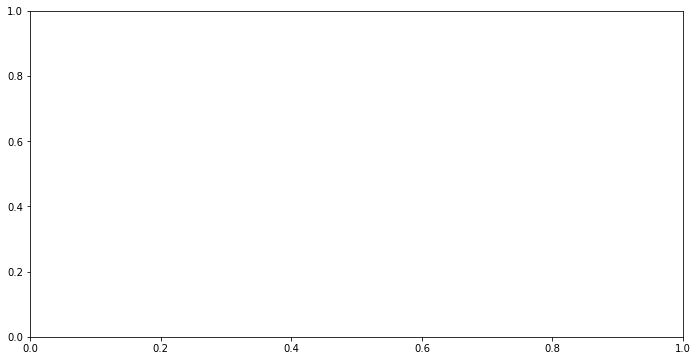

In [305]:
plt.gca().get_ylim()